# Exploratory Data Analysis

In [853]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import display
pd.options.display.max_columns = None
above = '../../../'

## Final dropping of columns

In [854]:
# Read in the final merge **change the name to the actual file once its done
data = pd.read_pickle(above + 'merged-sales-val-macro-dem-crime.pkl')
# Columns to drop
drop = ["s_neighborhood", "s_building_class_category", "s_block", "s_lot", "s_address", "s_apt_number", 
        "s_gross_sqft", "s_tax_class_at_sale", "s_residential_units", "s_commercial_units",
        "s_year", "v_bldgcl", "v_bldfront", "a_year_month", "s_borough_code", "c_year_month"]

data.drop(drop, axis =1, inplace=True)
# protect = ["s_bbl", "s_sale_price","s_sale_date"]
num_rows = data.shape[0]

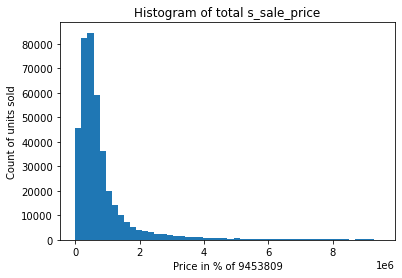

In [855]:
# Histogram of the sales vs 
def hist_col(data, col, b):
    data99_max = data[data[col] <= np.percentile(data[col],99)][col].max()
    plt.hist(data[col],bins=b, range=(0, np.percentile(data[col],99)))
    plt.xlabel(f'Price in % of {data99_max}')
    plt.ylabel("Count of units sold")
    plt.title('Histogram of total ' + col)
    plt.show()
hist_col(data, 's_sale_price', 50)

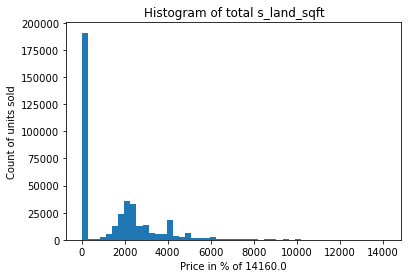

In [856]:
hist_col(data, "s_land_sqft", 50)

In [857]:
# Number of 0 values in sales s_land_sqft
print(f'Zero values for sqft of land in Sales: {((data.s_land_sqft) == 0).sum()}')
# Number of 0 values in valuation lotfront or lotdepth
print(f'Zero values for sqft in Valuation: {((data.v_ltfront * data.v_ltdepth) == 0).sum()}')
# Where we have 0 values in either sales or valuation
miss_area = data[(data.s_land_sqft == 0) & ((data.v_ltfront * data.v_ltdepth) == 0)]
print(f'Total number of missing values for area that we can not impute {miss_area.shape[0]}')

Zero values for sqft of land in Sales: 190922
Zero values for sqft in Valuation: 64477
Total number of missing values for area that we can not impute 62072


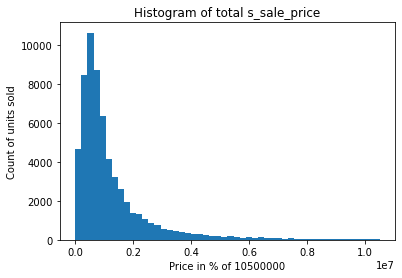

In [858]:
# Histogram of sales with missing values for square footage
hist_col(miss_area, 's_sale_price', 50)

In [859]:
# Missing area by year
miss_area.groupby(miss_area.s_sale_year).s_borough.count()

s_sale_year
2011    7762
2012    8225
2013    8827
2014    7991
2015    7654
2016    7618
2017    8420
2018    5575
Name: s_borough, dtype: int64

## Imputing the missing Area

In [860]:
# Remove all rows that we can not impute
data.drop(axis =0, index = miss_area.index, inplace=True)
print(f'Check that right number rows dropped. Original - New: {num_rows - data.shape[0]} Non imputable: {miss_area.shape[0]}')

Check that right number rows dropped. Original - New: 62072 Non imputable: 62072


In [861]:
# Get rid of the original index values that are no longer applicable
data = data.reset_index(drop=True)

In [862]:
data["prod_vf_vd"] = data.v_ltfront * data.v_ltdepth
def create_imputed_land_area(row):
    if row["s_land_sqft"] == 0:
        return row["prod_vf_vd"]
    else:
        return row["s_land_sqft"]
data["imputed_land_area"] = data.apply(lambda row: create_imputed_land_area(row), axis=1)

In [863]:
# Sanity check that there are no zero values for area
print(f'Count of missing area values:{(data.imputed_land_area == 0).sum()}')
# Compare the square footage of the imputed area and product of v_ltfront and v_ltdepth
np.abs((data.imputed_land_area - data.prod_vf_vd)).sum()/(data.imputed_land_area.sum())

Count of missing area values:0


0.024416456202426832

In [864]:
drop = ["s_land_sqft", "v_ltfront", "v_ltdepth", "prod_vf_vd"]
data.drop(drop, axis =1, inplace=True)

## Imputing Total Units? Should we do median imputation?

In [865]:
"""It makes sense that cooperatives would have no information on the number of units 
available within the apartment as the building is owned by everyone as a whole and 
it is then split up amongst the residents. As a result all of the cooperatives will not have total """

data[(data.s_building_class_at_sale == "C6") 
     | (data.s_building_class_at_sale == "D0") 
     | (data.s_building_class_at_sale == "D4")].shape[0]

114268

In [866]:
data[data.s_total_units == 0].groupby(data.s_building_class_at_sale).count()

,s_borough,s_zipcode,s_total_units,s_year_built,s_building_class_at_sale,s_sale_price,s_sale_date,s_bbl,v_stories,v_fullval,v_latitude,v_longitude,v_nta,s_sale_month,s_sale_year,m_10yr_treasury_constant_maturity_rate,m_30yr_fixed_rate_mortgage_avg_in_us,m_case_shiller_ny_home_price_index,m_case_shiller_us_national_home_price_index,m_consumer_price_index,m_core_cpi,m_effective_fed_funds_rate,m_inflation_rate,m_population_level,m_real_gross_domestic_product,m_sp500_index,m_unemployment_rate,m_us_real_median_household_income,m_10yr_treasury_constant_maturity_rate_%chg,m_30yr_fixed_rate_mortgage_avg_in_us_%chg,m_case_shiller_ny_home_price_index_%chg,m_case_shiller_us_national_home_price_index_%chg,m_consumer_price_index_%chg,m_core_cpi_%chg,m_effective_fed_funds_rate_%chg,m_inflation_rate_%chg,m_population_level_%chg,m_real_gross_domestic_product_%chg,m_sp500_index_%chg,m_unemployment_rate_%chg,m_us_real_median_household_income_%chg,d_pop_25_years_and_over,d_less_than_9th_grade,d_less_than_9th_grade_pct,d_9th_to_12th_grade_no_diploma,d_9th_to_12th_grade_no_diploma_pct,d_high_school_graduate,d_high_school_graduate_pct,d_some_college_no_degree,d_some_college_no_degree_pct,d_associates_degree,d_associates_degree_pct,d_bachelors_degree,d_bachelors_degree_pct,d_graduate_or_professional_degree,d_graduate_or_professional_degree_pct,d_total_population,d_white_population,d_white_population_pct,d_black_or_african_american_population,d_black_or_african_american_population_pct,d_american_indian_and_alaska_native_population,d_american_indian_and_alaska_native_population_pct,d_asian_population,d_asian_population_pct,d_native_hawaiian_and_other_pacific_islander_population,d_native_hawaiian_and_other_pacific_islander_population_pct,d_some_other_race_population,d_some_other_race_population_pct,d_total_housing_units,d_no_bedroom_units,d_no_bedroom_units_pct,d_1_bedroom_units,d_1_bedroom_units_pct,d_2_bedroom_units,d_2_bedroom_units_pct,d_3_bedroom_units,d_3_bedroom_units_pct,d_4_bedroom_units,d_4_bedroom_units_pct,d_5_bedroom_units,d_5_bedroom_units_pct,d_owner_occupied_units,d_units_less_than_50000,d_units_less_than_50000_pct,d_units_from_50000_to_99999,d_units_from_50000_to_99999_pct,d_units_from_100000_to_149999,d_units_from_100000_to_149999_pct,d_units_from_150000_to_199999,d_units_from_150000_to_199999_pct,d_units_from_200000_to_299999,d_units_from_200000_to_299999_pct,d_units_from_300000_to_499999,d_units_from_300000_to_499999_pct,d_units_from_500000_to_999999,d_units_from_500000_to_999999_pct,d_units_1000000_or_more,d_units_1000000_or_more_pct,d_median_housing_price,d_total_households,d_households_less_than_10000,d_households_less_than_10000_pct,d_households_from_10000_to_14999,d_households_from_10000_to_14999_pct,d_households_from_15000_to_24999,d_households_from_15000_to_24999_pct,d_households_from_25000_to_34999,d_households_from_25000_to_34999_pct,d_households_from_35000_to_49999,d_households_from_35000_to_49999_pct,d_households_from_50000_to_74999,d_households_from_50000_to_74999_pct,d_households_from_75000_to_99999,d_households_from_75000_to_99999_pct,d_households_from_100000_to_149999,d_households_from_100000_to_149999_pct,d_households_from_150000_to_199999,d_households_from_150000_to_199999_pct,d_households_200000_or_more,d_households_200000_or_more_pct,d_median_household_income_dollars,d_mean_household_income_dollars,a_count,c_count,imputed_land_area
s_building_class_at_sale,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A1,10,10,10,10,10,10,10,10,9,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10
A2,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3

In [867]:
# This is the count of rows for each total number of units (first 20 values) 
data.groupby(data.s_total_units).count().s_borough.head(20)

s_total_units
0.0     114369
1.0     107307
2.0      72671
3.0      22857
4.0       5684
5.0       1712
6.0       3864
7.0        831
8.0       1648
9.0        591
10.0       807
11.0       316
12.0       308
13.0       139
14.0       164
15.0       210
16.0       492
17.0       188
18.0       179
19.0       119
Name: s_borough, dtype: int64

In [868]:
data.describe()

,s_borough,s_zipcode,s_total_units,s_year_built,s_sale_price,v_stories,v_fullval,v_latitude,v_longitude,s_sale_month,s_sale_year,m_10yr_treasury_constant_maturity_rate,m_30yr_fixed_rate_mortgage_avg_in_us,m_case_shiller_ny_home_price_index,m_case_shiller_us_national_home_price_index,m_consumer_price_index,m_core_cpi,m_effective_fed_funds_rate,m_inflation_rate,m_population_level,m_real_gross_domestic_product,m_sp500_index,m_unemployment_rate,m_us_real_median_household_income,m_10yr_treasury_constant_maturity_rate_%chg,m_30yr_fixed_rate_mortgage_avg_in_us_%chg,m_case_shiller_ny_home_price_index_%chg,m_case_shiller_us_national_home_price_index_%chg,m_consumer_price_index_%chg,m_core_cpi_%chg,m_effective_fed_funds_rate_%chg,m_inflation_rate_%chg,m_population_level_%chg,m_real_gross_domestic_product_%chg,m_sp500_index_%chg,m_unemployment_rate_%chg,m_us_real_median_household_income_%chg,d_pop_25_years_and_over,d_less_than_9th_grade,d_less_than_9th_grade_pct,d_9th_to_12th_grade_no_diploma,d_9th_to_12th_grade_no_diploma_pct,d_high_school_graduate,d_high_school_graduate_pct,d_some_college_no_degree,d_some_college_no_degree_pct,d_associates_degree,d_associates_degree_pct,d_bachelors_degree,d_bachelors_degree_pct,d_graduate_or_professional_degree,d_graduate_or_professional_degree_pct,d_total_population,d_white_population,d_white_population_pct,d_black_or_african_american_population,d_black_or_african_american_population_pct,d_american_indian_and_alaska_native_population,d_american_indian_and_alaska_native_population_pct,d_asian_population,d_asian_population_pct,d_native_hawaiian_and_other_pacific_islander_population,d_native_hawaiian_and_other_pacific_islander_population_pct,d_some_other_race_population,d_some_other_race_population_pct,d_total_housing_units,d_no_bedroom_units,d_no_bedroom_units_pct,d_1_bedroom_units,d_1_bedroom_units_pct,d_2_bedroom_units,d_2_bedroom_units_pct,d_3_bedroom_units,d_3_bedroom_units_pct,d_4_bedroom_units,d_4_bedroom_units_pct,d_5_bedroom_units,d_5_bedroom_units_pct,d_owner_occupied_units,d_units_less_than_50000,d_units_less_than_50000_pct,d_units_from_50000_to_99999,d_units_from_50000_to_99999_pct,d_units_from_100000_to_149999,d_units_from_100000_to_149999_pct,d_units_from_150000_to_199999,d_units_from_150000_to_199999_pct,d_units_from_200000_to_299999,d_units_from_200000_to_299999_pct,d_units_from_300000_to_499999,d_units_from_300000_to_499999_pct,d_units_from_500000_to_999999,d_units_from_500000_to_999999_pct,d_units_1000000_or_more,d_units_1000000_or_more_pct,d_median_housing_price,d_total_households,d_households_less_than_10000,d_households_less_than_10000_pct,d_households_from_10000_to_14999,d_households_from_10000_to_14999_pct,d_households_from_15000_to_24999,d_households_from_15000_to_24999_pct,d_households_from_25000_to_34999,d_households_from_25000_to_34999_pct,d_households_from_35000_to_49999,d_households_from_35000_to_49999_pct,d_households_from_50000_to_74999,d_households_from_50000_to_74999_pct,d_households_from_75000_to_99999,d_households_from_75000_to_99999_pct,d_households_from_100000_to_149999,d_households_from_100000_to_149999_pct,d_households_from_150000_to_199999,d_households_from_150000_to_199999_pct,d_households_200000_or_more,d_households_200000_or_more_pct,d_median_household_income_dollars,d_mean_household_income_dollars,a_count,c_count,imputed_land_area
count,339718.000000,339718.000000,339718.000000,339718.000000,3.397180e+05,338064.000000,3.397180e+05,337942.000000,337942.000000,339718.000000,339718.000000,339718.000000,339718.000000,339718.000000,339718.000000,339718.000000,339718.000000,339718.000000,339718.000000,339718.000000,339718.000000,339718.000000,339718.000000,339718.000000,339718.000000,339718.000000,339718.000000,339718.000000,339718.000000,339718.000000,339718.000000,339718.000000,339718.000000,339718.000000,339718.000000,339718.000000,339718.000000,3.397180e+05,339718.000000,339718.000000,339718.000000,339718.000000,339718.000000,339718.000000,339718.000000,339718.00

In [869]:
# The median of sales price 
print(data.s_sale_price.median())
# The median of the valuation assessment
print(data.v_fullval.median())
# The median difference between the sales price and the valuation assessment
print(np.abs(data.s_sale_price - data.v_fullval).median())

500000.0
691000.0
342000.0


In [870]:
# Double check that there are no missing values anywhere
data.columns[data.isnull().sum() != 0]

Index(['v_stories', 'v_latitude', 'v_longitude', 'v_nta'], dtype='object')

## Last Imputation of Missing Values

In [871]:
miss_v_stories = data.v_stories[data.v_stories.isnull()].index.to_numpy()
len(miss_v_stories)

1654

In [872]:
data.at[miss_v_stories, "v_stories"] = 0

In [873]:
(data.v_stories == 0).sum()

1654

There are only 1654 rows where we having missing number of stories. For now we can leave this data in and just set the value of v_stories in these rows to 0.

In [874]:
miss_v_latitude = data.v_latitude[data.v_latitude.isnull()].index.to_numpy()
miss_v_longitude = data.v_longitude[data.v_longitude.isnull()].index.to_numpy()
print(len(miss_v_latitude))
print((miss_v_latitude - miss_v_longitude).sum())
data.drop(axis =0, index = miss_v_latitude, inplace=True)

1776
0


In [875]:
# Get rid of the original index values that are no longer applicable
data = data.reset_index(drop=True)

It looks like there are 1776 rows with missing latitude longitude pairs and there in every row that is missing either lat or lon it is missing both values. We will drop these rows as we wish to have the crime data engineered using these coordinates.

In [876]:
len(data.v_nta[data.v_nta.isnull()])

0

# Feature Selection

In [877]:
data.head(1)

,s_borough,s_zipcode,s_total_units,s_year_built,s_building_class_at_sale,s_sale_price,s_sale_date,s_bbl,v_stories,v_fullval,v_latitude,v_longitude,v_nta,s_sale_month,s_sale_year,m_10yr_treasury_constant_maturity_rate,m_30yr_fixed_rate_mortgage_avg_in_us,m_case_shiller_ny_home_price_index,m_case_shiller_us_national_home_price_index,m_consumer_price_index,m_core_cpi,m_effective_fed_funds_rate,m_inflation_rate,m_population_level,m_real_gross_domestic_product,m_sp500_index,m_unemployment_rate,m_us_real_median_household_income,m_10yr_treasury_constant_maturity_rate_%chg,m_30yr_fixed_rate_mortgage_avg_in_us_%chg,m_case_shiller_ny_home_price_index_%chg,m_case_shiller_us_national_home_price_index_%chg,m_consumer_price_index_%chg,m_core_cpi_%chg,m_effective_fed_funds_rate_%chg,m_inflation_rate_%chg,m_population_level_%chg,m_real_gross_domestic_product_%chg,m_sp500_index_%chg,m_unemployment_rate_%chg,m_us_real_median_household_income_%chg,d_pop_25_years_and_over,d_less_than_9th_grade,d_less_than_9th_grade_pct,d_9th_to_12th_grade_no_diploma,d_9th_to_12th_grade_no_diploma_pct,d_high_school_graduate,d_high_school_graduate_pct,d_some_college_no_degree,d_some_college_no_degree_pct,d_associates_degree,d_associates_degree_pct,d_bachelors_degree,d_bachelors_degree_pct,d_graduate_or_professional_degree,d_graduate_or_professional_degree_pct,d_total_population,d_white_population,d_white_population_pct,d_black_or_african_american_population,d_black_or_african_american_population_pct,d_american_indian_and_alaska_native_population,d_american_indian_and_alaska_native_population_pct,d_asian_population,d_asian_population_pct,d_native_hawaiian_and_other_pacific_islander_population,d_native_hawaiian_and_other_pacific_islander_population_pct,d_some_other_race_population,d_some_other_race_population_pct,d_total_housing_units,d_no_bedroom_units,d_no_bedroom_units_pct,d_1_bedroom_units,d_1_bedroom_units_pct,d_2_bedroom_units,d_2_bedroom_units_pct,d_3_bedroom_units,d_3_bedroom_units_pct,d_4_bedroom_units,d_4_bedroom_units_pct,d_5_bedroom_units,d_5_bedroom_units_pct,d_owner_occupied_units,d_units_less_than_50000,d_units_less_than_50000_pct,d_units_from_50000_to_99999,d_units_from_50000_to_99999_pct,d_units_from_100000_to_149999,d_units_from_100000_to_149999_pct,d_units_from_150000_to_199999,d_units_from_150000_to_199999_pct,d_units_from_200000_to_299999,d_units_from_200000_to_299999_pct,d_units_from_300000_to_499999,d_units_from_300000_to_499999_pct,d_units_from_500000_to_999999,d_units_from_500000_to_999999_pct,d_units_1000000_or_more,d_units_1000000_or_more_pct,d_median_housing_price,d_total_households,d_households_less_than_10000,d_households_less_than_10000_pct,d_households_from_10000_to_14999,d_households_from_10000_to_14999_pct,d_households_from_15000_to_24999,d_households_from_15000_to_24999_pct,d_households_from_25000_to_34999,d_households_from_25000_to_34999_pct,d_households_from_35000_to_49999,d_households_from_35000_to_49999_pct,d_households_from_50000_to_74999,d_households_from_50000_to_74999_pct,d_households_from_75000_to_99999,d_households_from_75000_to_99999_pct,d_households_from_100000_to_149999,d_households_from_100000_to_149999_pct,d_households_from_150000_to_199999,d_households_from_150000_to_199999_pct,d_households_200000_or_more,d_households_200000_or_more_pct,d_median_household_income_dollars,d_mean_household_income_dollars,a_count,c_count,imputed_land_area
0,2,10458.0,1.0,1910.0,A1,329000,2011-01-19,2030390064,2.0,365000,40.856635,-73.892647,Claremont-Bathgate,1,2011,3.391905,4.755,167.18963,141.525,221.187,222.803,0.168387,3.156842,311023.0,15712.754,1283.124286,9.1,57021.0,0.02907,0.008697,-0.006628,-0.003766,0.003243,0.002069,-0.080986,0.04171,0.000531,-0.000803,0.032955,-0.021505,-0.001289,861146,137783.36,0.16,126588.462,0.147,237676.296,0.276,145533.674,0.169,63724.804,0.074,95587.206,0.111,54252.198,0.063,1392002.0,342432.492,0.246,503904.724,0.362,13920.02,0.01,55680.08,0.04,2784.004,0.002,524784.754,0.377,512320,30739.2,0.06,1695

In [878]:
# Find the categorical columns to convert
cat_col = data.select_dtypes(exclude=['int64', 'float']).columns.to_list()
print(cat_col)
# We will do other feature engineering with s_sale_date
cat_col.remove('s_sale_date')
# s_bbl is not a categorical column, but we should make it an integer value instead of a string
cat_col.remove('s_bbl')
data.s_bbl = data.s_bbl.astype('int64')
print(cat_col)

['s_building_class_at_sale', 's_sale_date', 's_bbl', 'v_nta']
['s_building_class_at_sale', 'v_nta']


Feature engineering the Datetime variable to convert it to numerical https://towardsdatascience.com/machine-learning-with-datetime-feature-engineering-predicting-healthcare-appointment-no-shows-5e4ca3a85f96#:~:text=Dates%20and%20times%20are%20rich,turn%20them%20into%20numerical%20data.

In [879]:
# We have to use ordinal encoding to transform the categorical to numerical
from numpy import asarray
from sklearn.preprocessing import OrdinalEncoder

# Create transformation function, input data and list of categorical columns, returns replace map
def ordinal_map(df, cols):
    replace_map = {}
    encoder = OrdinalEncoder()
    encoder.fit(data[cols])
    cats = encoder.categories_
    for i in range(len(cols)):
        c =  data[cat_col[i]].unique().tolist()        
        o = list(map(lambda x:[x], c)) 
        result = encoder.fit_transform(o)
        cat = cats[i]
        replace_map[cols[i]] = {k: v for k,v in zip(cats[i], [x[0] for x in result.tolist()])}
    return replace_map

r_map = to_ordinal(data, cat_col)
data.replace(r_map, inplace=True)

In [880]:
data.head(5)

,s_borough,s_zipcode,s_total_units,s_year_built,s_building_class_at_sale,s_sale_price,s_sale_date,s_bbl,v_stories,v_fullval,v_latitude,v_longitude,v_nta,s_sale_month,s_sale_year,m_10yr_treasury_constant_maturity_rate,m_30yr_fixed_rate_mortgage_avg_in_us,m_case_shiller_ny_home_price_index,m_case_shiller_us_national_home_price_index,m_consumer_price_index,m_core_cpi,m_effective_fed_funds_rate,m_inflation_rate,m_population_level,m_real_gross_domestic_product,m_sp500_index,m_unemployment_rate,m_us_real_median_household_income,m_10yr_treasury_constant_maturity_rate_%chg,m_30yr_fixed_rate_mortgage_avg_in_us_%chg,m_case_shiller_ny_home_price_index_%chg,m_case_shiller_us_national_home_price_index_%chg,m_consumer_price_index_%chg,m_core_cpi_%chg,m_effective_fed_funds_rate_%chg,m_inflation_rate_%chg,m_population_level_%chg,m_real_gross_domestic_product_%chg,m_sp500_index_%chg,m_unemployment_rate_%chg,m_us_real_median_household_income_%chg,d_pop_25_years_and_over,d_less_than_9th_grade,d_less_than_9th_grade_pct,d_9th_to_12th_grade_no_diploma,d_9th_to_12th_grade_no_diploma_pct,d_high_school_graduate,d_high_school_graduate_pct,d_some_college_no_degree,d_some_college_no_degree_pct,d_associates_degree,d_associates_degree_pct,d_bachelors_degree,d_bachelors_degree_pct,d_graduate_or_professional_degree,d_graduate_or_professional_degree_pct,d_total_population,d_white_population,d_white_population_pct,d_black_or_african_american_population,d_black_or_african_american_population_pct,d_american_indian_and_alaska_native_population,d_american_indian_and_alaska_native_population_pct,d_asian_population,d_asian_population_pct,d_native_hawaiian_and_other_pacific_islander_population,d_native_hawaiian_and_other_pacific_islander_population_pct,d_some_other_race_population,d_some_other_race_population_pct,d_total_housing_units,d_no_bedroom_units,d_no_bedroom_units_pct,d_1_bedroom_units,d_1_bedroom_units_pct,d_2_bedroom_units,d_2_bedroom_units_pct,d_3_bedroom_units,d_3_bedroom_units_pct,d_4_bedroom_units,d_4_bedroom_units_pct,d_5_bedroom_units,d_5_bedroom_units_pct,d_owner_occupied_units,d_units_less_than_50000,d_units_less_than_50000_pct,d_units_from_50000_to_99999,d_units_from_50000_to_99999_pct,d_units_from_100000_to_149999,d_units_from_100000_to_149999_pct,d_units_from_150000_to_199999,d_units_from_150000_to_199999_pct,d_units_from_200000_to_299999,d_units_from_200000_to_299999_pct,d_units_from_300000_to_499999,d_units_from_300000_to_499999_pct,d_units_from_500000_to_999999,d_units_from_500000_to_999999_pct,d_units_1000000_or_more,d_units_1000000_or_more_pct,d_median_housing_price,d_total_households,d_households_less_than_10000,d_households_less_than_10000_pct,d_households_from_10000_to_14999,d_households_from_10000_to_14999_pct,d_households_from_15000_to_24999,d_households_from_15000_to_24999_pct,d_households_from_25000_to_34999,d_households_from_25000_to_34999_pct,d_households_from_35000_to_49999,d_households_from_35000_to_49999_pct,d_households_from_50000_to_74999,d_households_from_50000_to_74999_pct,d_households_from_75000_to_99999,d_households_from_75000_to_99999_pct,d_households_from_100000_to_149999,d_households_from_100000_to_149999_pct,d_households_from_150000_to_199999,d_households_from_150000_to_199999_pct,d_households_200000_or_more,d_households_200000_or_more_pct,d_median_household_income_dollars,d_mean_household_income_dollars,a_count,c_count,imputed_land_area
0,2,10458.0,1.0,1910.0,11.0,329000,2011-01-19,2030390064,2.0,365000,40.856635,-73.892647,181.0,1,2011,3.391905,4.755,167.18963,141.525,221.187,222.803,0.168387,3.156842,311023.0,15712.754,1283.124286,9.1,57021.0,0.02907,0.008697,-0.006628,-0.003766,0.003243,0.002069,-0.080986,0.04171,0.000531,-0.000803,0.032955,-0.021505,-0.001289,861146,137783.36,0.16,126588.462,0.147,237676.296,0.276,145533.674,0.169,63724.804,0.074,95587.206,0.111,54252.198,0.063,1392002.0,342432.492,0.246,503904.724,0.362,13920.02,0.01,55680.08,0.04,2784.004,0.002,524784.754,0.377,512320,30739.2,0.06,169577.92,0.331

In [882]:
# Remove this after the feature engineering is done for datetime?
data.drop(columns = ['s_sale_date'], inplace=True)

In [883]:
data.abs()

,s_borough,s_zipcode,s_total_units,s_year_built,s_building_class_at_sale,s_sale_price,s_bbl,v_stories,v_fullval,v_latitude,v_longitude,v_nta,s_sale_month,s_sale_year,m_10yr_treasury_constant_maturity_rate,m_30yr_fixed_rate_mortgage_avg_in_us,m_case_shiller_ny_home_price_index,m_case_shiller_us_national_home_price_index,m_consumer_price_index,m_core_cpi,m_effective_fed_funds_rate,m_inflation_rate,m_population_level,m_real_gross_domestic_product,m_sp500_index,m_unemployment_rate,m_us_real_median_household_income,m_10yr_treasury_constant_maturity_rate_%chg,m_30yr_fixed_rate_mortgage_avg_in_us_%chg,m_case_shiller_ny_home_price_index_%chg,m_case_shiller_us_national_home_price_index_%chg,m_consumer_price_index_%chg,m_core_cpi_%chg,m_effective_fed_funds_rate_%chg,m_inflation_rate_%chg,m_population_level_%chg,m_real_gross_domestic_product_%chg,m_sp500_index_%chg,m_unemployment_rate_%chg,m_us_real_median_household_income_%chg,d_pop_25_years_and_over,d_less_than_9th_grade,d_less_than_9th_grade_pct,d_9th_to_12th_grade_no_diploma,d_9th_to_12th_grade_no_diploma_pct,d_high_school_graduate,d_high_school_graduate_pct,d_some_college_no_degree,d_some_college_no_degree_pct,d_associates_degree,d_associates_degree_pct,d_bachelors_degree,d_bachelors_degree_pct,d_graduate_or_professional_degree,d_graduate_or_professional_degree_pct,d_total_population,d_white_population,d_white_population_pct,d_black_or_african_american_population,d_black_or_african_american_population_pct,d_american_indian_and_alaska_native_population,d_american_indian_and_alaska_native_population_pct,d_asian_population,d_asian_population_pct,d_native_hawaiian_and_other_pacific_islander_population,d_native_hawaiian_and_other_pacific_islander_population_pct,d_some_other_race_population,d_some_other_race_population_pct,d_total_housing_units,d_no_bedroom_units,d_no_bedroom_units_pct,d_1_bedroom_units,d_1_bedroom_units_pct,d_2_bedroom_units,d_2_bedroom_units_pct,d_3_bedroom_units,d_3_bedroom_units_pct,d_4_bedroom_units,d_4_bedroom_units_pct,d_5_bedroom_units,d_5_bedroom_units_pct,d_owner_occupied_units,d_units_less_than_50000,d_units_less_than_50000_pct,d_units_from_50000_to_99999,d_units_from_50000_to_99999_pct,d_units_from_100000_to_149999,d_units_from_100000_to_149999_pct,d_units_from_150000_to_199999,d_units_from_150000_to_199999_pct,d_units_from_200000_to_299999,d_units_from_200000_to_299999_pct,d_units_from_300000_to_499999,d_units_from_300000_to_499999_pct,d_units_from_500000_to_999999,d_units_from_500000_to_999999_pct,d_units_1000000_or_more,d_units_1000000_or_more_pct,d_median_housing_price,d_total_households,d_households_less_than_10000,d_households_less_than_10000_pct,d_households_from_10000_to_14999,d_households_from_10000_to_14999_pct,d_households_from_15000_to_24999,d_households_from_15000_to_24999_pct,d_households_from_25000_to_34999,d_households_from_25000_to_34999_pct,d_households_from_35000_to_49999,d_households_from_35000_to_49999_pct,d_households_from_50000_to_74999,d_households_from_50000_to_74999_pct,d_households_from_75000_to_99999,d_households_from_75000_to_99999_pct,d_households_from_100000_to_149999,d_households_from_100000_to_149999_pct,d_households_from_150000_to_199999,d_households_from_150000_to_199999_pct,d_households_200000_or_more,d_households_200000_or_more_pct,d_median_household_income_dollars,d_mean_household_income_dollars,a_count,c_count,imputed_land_area
0,2.0,10458.0,1.0,1910.0,11.0,329000.0,2.030390e+09,2.0,365000.0,40.856635,73.892647,181.0,1.0,2011.0,3.391905,4.755,167.189630,141.525,221.187,222.803,0.168387,3.156842,311023.0,15712.754,1283.124286,9.1,57021.00,0.029070,0.008697,0.006628,0.003766,0.003243,0.002069,0.080986,0.041710,0.000531,0.000803,0.032955,0.021505,0.001289,861146.0,137783.360,0.160,126588.462,0.147,237676.296,0.276,145533.674,0.169,63724.804,0.074,95587.206,0.111,54252.198,0.063,1392002.0,342432.492,0.246,503904.724,0.362,13920.020,0.010,55680.08,0.04,2784.004,0.002,524784.754,0.377,512320.0,30739.200,0.060,169577.920,0.331,1

In [884]:
import pandas as pd
import numpy as np

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2


X = data.loc[:, data.columns != 's_sale_price'].abs()  #independent columns
Y = data.loc[:, data.columns == 's_sale_price']    #target column sales price

Maybe I should be using this for normalizing the data instead of taking the absoulte value of the dataframe to get rid of negative values https://stats.stackexchange.com/questions/341332/how-to-scale-for-selectkbest-for-feature-selection

In [ ]:
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print 10 best features